# Partie spark

In [12]:
from pyspark.sql import functions as F  
from pyspark.sql import SparkSession    
from pyspark.sql.functions import col   
import warnings 
import os
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import dash
from dash import dcc, html , Output, Input
from dash import html
import plotly.express as px
import pandas as pd
import base64

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Initialisation de la session spark 

In [2]:
#spark session 
spark_session = SparkSession.builder.appName('data_film').getOrCreate()
print( f"initialisation de la session spark :  {spark_session} " )

23/02/23 19:48:50 WARN Utils: Your hostname, codespaces-46969e resolves to a loopback address: 127.0.0.1; using 172.16.5.4 instead (on interface eth0)
23/02/23 19:48:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/23 19:48:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
initialisation de la session spark :  <pyspark.sql.session.SparkSession object at 0x7f6b9c2eb6d0> 


Lecture de la base de données

In [3]:

data = spark_session.read.option("delimiter", "\t").csv(r'./data/data_film.txt', header=False)
data = data.toDF('titre', 'date', 'duree', 'type', 'note', 'nombre avis', 'avis')

print('Base de données brute : ')
print("--------------------------")
print()
print(data.show())


Base de données brute : 
--------------------------

+--------------------+----------------+--------+--------------------+----+-----------+--------------------+
|               titre|            date|   duree|                type|note|nombre avis|                avis|
+--------------------+----------------+--------+--------------------+----+-----------+--------------------+
|       The Fabelmans| 22 février 2023|2h 31min| ['Biopic', 'Drame']| 4.3|        133|['\nC’est peut-êt...|
|              Mayday| 25 janvier 2023|1h 48min|['Action', 'Thril...| 3.5|        208|['\n"Mayday" est ...|
|    La Famille Asada| 25 janvier 2023|2h 07min|         ['Comédie']| 4.1|        139|["\nTrès bon mome...|
|             Babylon| 18 janvier 2023|3h 09min|['Historique', 'D...| 4.2|        224|["\nBabylonDans c...|
|Le Retour des hir...|  8 février 2023|2h 13min|           ['Drame']| 4.1|         34|["\nEn septembre ...|
|        L'Astronaute| 15 février 2023|1h 50min|['Comédie dramati...| 4.0|         

Traitement des variables

In [4]:

print('debut traitement des variables')

# traitment variable avis 
data = data.withColumn("avis", F.regexp_replace(F.col("avis"), "[\['\"0-9]" , ""))

# traitment de la variable type
data = data.withColumn("type", F.regexp_replace(F.col("type"), "[\[\]',]", ""))

# traitement variable heure : ne garder que l'heure pour des besoin de modélisation 
data = data.withColumn('duree', F.substring("duree", 1, 1))


debut traitement des variables


Traitement des dates

In [5]:
# encoder la variable date afin de passer du format francais a un format usuel  
print('traitement des dates')

data = data.withColumn("date", F.regexp_replace('date','août', "08"))
data = data.withColumn("date", F.regexp_replace('date','avril', "04"))
data = data.withColumn("date", F.regexp_replace('date','décembre', "12"))
data = data.withColumn("date", F.regexp_replace('date','février', "02"))
data = data.withColumn("date", F.regexp_replace('date','janvier', "01"))
data = data.withColumn("date", F.regexp_replace('date','juillet', "07"))
data = data.withColumn("date", F.regexp_replace('date','juin', "06"))
data = data.withColumn("date", F.regexp_replace('date','mai', "05"))
data = data.withColumn("date", F.regexp_replace('date','novembre', "11"))
data = data.withColumn("date", F.regexp_replace('date','octobre', "10"))
data = data.withColumn("date", F.regexp_replace('date','septembre', "09"))

# changer le format des dates  
spark_session.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY") # car ne veut pas reconnaitre le format de base
data = data.withColumn("date", F.to_date("date", "dd MM yyyy"))


traitement des dates


# Word cloud

In [6]:
def word_cloud(title = 'Babylon', df = data) :

    """ fonction qui permet de créer un word cloud à partir des avis des films """

    # stop word 
    stop_words = set(stopwords.words('french'))
    
    # ajout des mots vides
    mots_vides = ["film", "\n","plus","a","sans","dans","sans","cette",'cet', "jour","encore","fait","comme","un","très", "tous","tout","cest","si",
    "cela", 'peut',  "être", "aussi", "mais","par","dont", "moi", "il", "toi", 'ils', "les",'quoi', "ca"] 
    stop_words.update(mots_vides) 

    # Filter the dataframe by title
    df = df.filter(df.titre == title)

    # Concatenate the 'avis' column values into a single string
    avis_string = ' '.join(df.select("avis").rdd.flatMap(lambda x: x).collect())

    # Définir le calque du nuage des mots
    wc = WordCloud(background_color="black", max_words=30, stopwords=stop_words, max_font_size=100, random_state=42)
    wc.generate(avis_string)  # "Calcul" du wordcloud

    # Obtenir un objet Image à partir de wc
    image = wc.to_image()
    # Enregistrer l'image en utilisant la méthode save de l'objet Image

    if not os.path.exists("./data"):
        os.mkdir("./data") 

    image.save(r'./data/word_cloud.png') 

    return wc.words_ 


# Recommandation

In [9]:
def recommandation(df = data):

    """ this function is used to make a recommandation of film to the user """


    # read df 

    df = data.toPandas()
    df1= df[['titre']]
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df = df[['note', 'nombre avis', 'duree', 'month']]

    # Standrad scaler for ACP 
    sc = StandardScaler()

    # normalistion du jeu de donnée
    X_normalise = sc.fit_transform(df)

    # réalisation de l'ACP
    acp = PCA() 
    acp.fit(X_normalise)
    new_columns = acp.transform(X_normalise) # Calculer les nouvelles colonnes obtenues par l'acp

    # Création d'un dataframe contenant 3 colonnes ( variable / correlation axe1 / correlation ax2)

    n,p = X_normalise.shape # nb individus  # nb variables
    eigval = ((n-1) / n) * acp.explained_variance_ # valeurs propres
    sqrt_eigval = np.sqrt(eigval) # racine carrée des valeurs propres
    corvar = np.zeros((p,p)) # matrice vide pour avoir les coordonnées
    for k in range(p):
        corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

    #kmeans afin d'afficher les films similaires
    km = KMeans(n_clusters=3).fit(X_normalise)
    preds = km.predict(X_normalise) # predictions pour chaque observation son cluster d'appartenance
    df['cluster'] = preds 

    # Representer graphiquement les departements sur les deux premieres composante de l'acp
    plt.scatter(new_columns[:, 0], new_columns[:, 1])
    colors = ['yellow','red','green']
    for label, x, y,c in zip(df1['titre'].str.strip().values, new_columns[:, 0], new_columns[:, 1],df['cluster']):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-5, 5),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc=colors[c], alpha=0.5),
            arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    if not os.path.exists("./data"):
        os.mkdir("./data") 

    # save image matplotlib 
    plt.savefig(r'./data/acp_k_means.png')

# Partie UI web

In [10]:
# afin de pouvoir utiliser les fonctions de plotly

df = data
df = df.toPandas()

In [13]:
# appel des fonctions afin de télécharger les fihciers nécéssaire à l'ui web
word_cloud()


{'cinéma': 1.0,
 'scène': 0.7272727272727273,
 'ça': 0.5909090909090909,
 'heure': 0.5909090909090909,
 'Babylon': 0.5454545454545454,
 'année': 0.5,
 'bien': 0.45454545454545453,
 'trop': 0.45454545454545453,
 'peu': 0.4090909090909091,
 'personnage': 0.36363636363636365,
 'Hollywood': 0.36363636363636365,
 'Chazelle': 0.36363636363636365,
 'Margot Robbie': 0.36363636363636365,
 'histoire': 0.3181818181818182,
 'toute': 0.3181818181818182,
 'rien': 0.2727272727272727,
 'moins': 0.2727272727272727,
 'mal': 0.2727272727272727,
 'autre': 0.2727272727272727,
 'faire': 0.2727272727272727,
 'musique': 0.2727272727272727,
 'dire': 0.2727272727272727,
 'montage': 0.2727272727272727,
 'grande': 0.2727272727272727,
 'dun': 0.2727272727272727,
 'déjà': 0.2727272727272727,
 'Brad Pitt': 0.2727272727272727,
 'Damien Chazelle': 0.2727272727272727,
 'autant': 0.22727272727272727,
 'débauche': 0.22727272727272727}

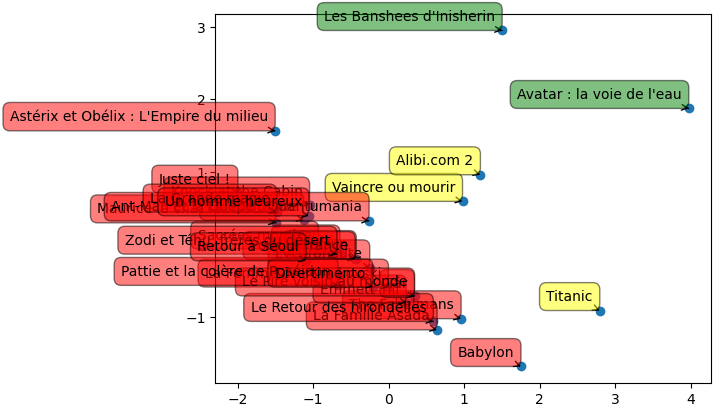

In [14]:
recommandation()

Graphique pour l'ui web

In [15]:
# Import the data for the first graph
fig1 = px.histogram(df, x="duree", title="Durée film")

image_filename = r"./data/word_cloud.png" 
encoded_image = base64.b64encode(open(image_filename, 'rb').read())

image_acp = r"./data/acp_k_means.png" 
encoded_image_acp = base64.b64encode(open(image_acp, 'rb').read())

# Import the data for the second graph
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
fig2 = px.histogram(df, x="month", title="Mois de sortie du film")

In [16]:
# Import the data for the third graph
def nettoyage_type(x) : 

    """nettoyage de la colonne type"""

    x['type'] = ' '.join( x['type'].split( )[:2]) 
    return x 

df_type = df.apply(nettoyage_type, axis = 1)
fig3 = px.histogram(df_type, x="type", title="Type de film")

Apllication dash

In [18]:
# Initialize the app

app = dash.Dash()

title_options = list(df['titre'].unique())

app.layout = html.Div([
    html.H1('RECOMMANDATION DE FILM'),
    html.P("""Cette application permet de recommander des films en fonction de votre choix.
    Une fois le film choisi, une nuage de mot apparaitra avec les mots les plus utilisés dans le synopsis du film.
    Ensuite, une recommandation sera faite en fonction de la similarité des films.
    Des statistiques sur l'ensemble de la base de données sont également disponibles."""),

    html.Div([
        dcc.Dropdown(
            id='title-dropdown',
            options=[{'label': title, 'value': title} for title in title_options],
            value=title_options[0]
        ),
        html.Div([
            html.Div(["Word Cloud"], style={'text-align': 'center', 'font-size': '100'}),
            html.Img(id='img',src='data:image/png;base64,{}'.format(encoded_image.decode()))
        ],style={'display': 'inline-block', 'width': '100%', 'text-align': 'center'}),
        html.Div([
            html.Div(["Recommendation : ACP + K-MEANS"], style={'text-align': 'center', 'font-size': '100'}),
            html.Img(id='img_acp',src='data:image/png;base64,{}'.format(encoded_image_acp.decode()))
        ],style={'display': 'inline-block', 'width': '100%', 'text-align': 'center'}),
        dcc.Graph(figure=fig1),
        dcc.Graph(figure=fig2),
        dcc.Graph(figure=fig3)
    ], style={'column-count': 2})
])


#Create callback function
@app.callback(Output('img', 'src'),
              [Input('title-dropdown', 'value')])
def update_image(title):

    """ Update the image"""

    word_cloud(title)
    image_filename = r"./data/word_cloud.png"
    encoded_image = base64.b64encode(open(image_filename, 'rb').read())
    return 'data:image/png;base64,{}'.format(encoded_image.decode())

# Run the app
if __name__ == '__main__':
    app.run_server(host='0.0.0.0')

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8050
 * Running on http://172.16.5.4:8050
Press CTRL+C to quit
127.0.0.1 - - [23/Feb/2023 19:53:22] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Feb/2023 19:53:22] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [23/Feb/2023 19:53:22] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [23/Feb/2023 19:53:22] "GET /_favicon.ico?v=2.8.1 HTTP/1.1" 200 -
127.0.0.1 - - [23/Feb/2023 19:53:23] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [23/Feb/2023 19:53:23] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [23/Feb/2023 19:53:23] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [23/Feb/2023 19:53:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [23/Feb/2023 19:53:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [23/Feb/2023 19:53:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0